# Detección de automóviles a partir de imágenes aéreas
## Implementación experimental
### Alumno: Luis Vasquez Espinoza
#### Fecha de entrega: 20-Octubre-2018

## Preparación de la data

El experimento inicia intentando hacernos una idea de cómo se debe ingresar la data a la red neuronal que implementaremos, por lo que primero necesitamos estudiar la data en sí. Haciendo uso de la librería *opencv* para python podemos revisar como está compuesta una subimágen de alguna de las tomas áreas disponibles.

In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("ground_truth_sets/Columbus_CSUAV_AFRL/Columbus_CSUAV_AFRL_1.png")
img_cars = cv2.imread("ground_truth_sets/Columbus_CSUAV_AFRL/Columbus_CSUAV_AFRL_1_Annotated_Cars.png")

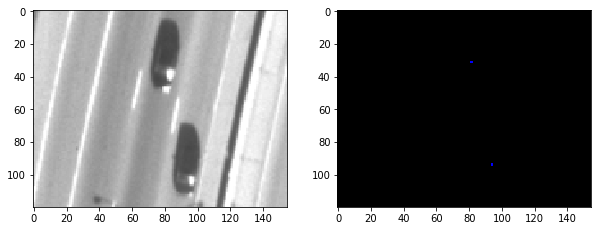

In [140]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(img[250:370,0:155])
plt.subplot(1, 2, 2)
plt.imshow(img_cars[250:370,0:155])

Si bien puede parecer que la imágen de la izquierda está compuesta por un solo canal al estar a escala de grises, en realidad *opencv* consideró los 3 canales al importarla, por lo que deberemos digerir esta matriz más adelante para considerar solamente dicho canal útil. En la imágen de la derecha notamos como se *rotularon* estos automóviles con su contraparte fotográfica, disponiendo de puntos diferentes al rgb(0,0,0) para distiguinr autos. Para saber como queremos detectar estos elementos preparé un par de métodos para darnos una idea de como se llevará a cabo la muestra de resultados.

In [141]:
def drawRect(img, center, margin):
    cv2.rectangle(img,(center[0] - margin, center[1] - margin),(center[0] + margin, center[1] + margin),(0,0,255),1)

def drawCircle(img, center, radius):
    cv2.circle(img, (center[0], center[1]), radius, (255,0,0),1)

Empleando *opencv* dibujaremos un rectángulo de lado ajustable para poder indicar los *bounds* de los autos presentes.
Además, se empleó el método **getCenters** para que al ingresar una matriz correspondiente a la imágen rotulada nos retorne las coordenadas de dichos puntos, de tal manera que correspondan a autos diferentes (de ahí el uso del *epsilon* para revisar pixeles contiguos que ensucian la información pertinente.)

[[81, 31], [94, 93]]


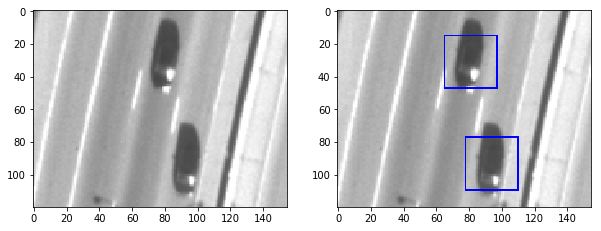

In [142]:
plt.figure(figsize=(10, 20))

sub_img = np.copy(img[250:370,0:155])
sub_img_cars = np.copy(img_cars[250:370,0:155])

plt.subplot(1, 2, 1)
plt.imshow(sub_img)

def getCenters(img):
    ref_pixels = np.argwhere(img > 0)[:,:2]
    epsilon = 2 # Two margin pixels for differentiating centers
    for i in range(ref_pixels.size):
        for j in range (i+1, len(ref_pixels)):
            if np.linalg.norm(ref_pixels[i]- ref_pixels[j]) <= epsilon:
                ref_pixels[j] = [0,0]
    
    centers = ref_pixels
    return [[c[1],c[0]] for c in centers if (c[0] != 0 and c[1] != 0)]
        
print(getCenters(sub_img_cars))

for c in getCenters(sub_img_cars):
    #print(c)
    drawRect(sub_img, c, 16)

plt.subplot(1, 2, 2)
plt.imshow(sub_img)

Además, debido a que no se dispone de una data de entrenamiento limpia para administrale a la red neuronal deberemos general la nuestra. En el artículo *Mundhenk, T. N., Konjevod, G., Sakla, W. A., & Boakye, K. (2016). ”A
Large Contextual Dataset for Classification, Detection and Counting of Cars with Deep Learning”* se explica de una manera elegante como el autor generó su propio dataset a partir de estas imágenes enormes. La idea principal es alimentar a la red neuronal de imágenes conteniendo un único auto, y que dicha red la clasifique como tal y la ubique, por lo que bastará dividir la imágen grande en subimágenes y fijar que en dicha subimágen existe un auto en la posición $x,y$ si es que el punto de rotulación está en un radio de tolerancia; es decir, la subimágen clasificará como auto si el auto está mas o menos en el centro de la subimágen, considerando cierto radio. Todo esto fue implementado en la función **getTrainY**

[77.5 60. ]
[1.   0.81 0.31]


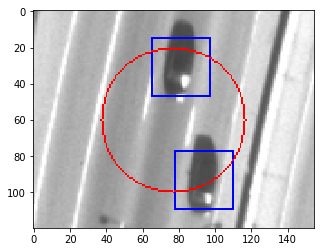

In [143]:
def getTrainY(image_center, width, height, centers, tol_radius, debug_flag = False):
    fixed_center = None
    min_distance = np.Inf
    for c in centers:
        distance = np.linalg.norm(image_center - c)
        if distance < min_distance and distance <= tol_radius:
            if debug_flag:
                print("centro: ", image_center, "|centro_i:", c, "|dist:", distance, "|tol:", tol_radius)
            min_distance = distance
            fixed_center = c
            
    if fixed_center is not None:
        return np.array([1, fixed_center[0]/height, fixed_center[1]/width])
    else:
        return np.array([0, -1, -1])

image_center = (np.array(sub_img.shape)/2)[0:2]
image_center = np.array([image_center[1], image_center[0]])
print(image_center)
radius = 40
drawCircle(sub_img, image_center.astype(int), radius)
print(getTrainY(image_center, 100, 100, getCenters(sub_img_cars), radius))
plt.imshow(sub_img)

Como se puede observar, dentro del radio de tolerancia se considera la primera ocurrencia de un auto, detectando así el punto de rotulación en $(81,31)$. Usted puede observar también que estos $y$ preparados para la red fueron normalizados. Habiendo escrito esto luego de terminada la experimentación aseguro que se obtienen mejores resultados si la salida es normalizada previamente, por lo que en el método **getTrainY** se dividió entre el ancho y alto de la subimagen. A continuación se aplica todo lo hecho hasta ahora en la primera imágen del primer dataset: Columbus.

In [144]:
# Generacion de base de datos a partir de Columbus (w:4965 x h:3313)
# Leyendo la imagen total

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Columbus_1 = cv2.imread("ground_truth_sets/Columbus_CSUAV_AFRL/Columbus_CSUAV_AFRL_1.png")
Columbus_1_Annotation = cv2.imread("ground_truth_sets/Columbus_CSUAV_AFRL/Columbus_CSUAV_AFRL_1_Annotated_Cars.png")

El método **prepareDataset** tomará ambas imágenes (la fotográfica y de rotulación), las dimensiones deseadas para las subimágenes (en width y height), el paso o stride de consideración y el radio de tolerancia para cada subimágen; y guardará tanto las subimágenes como su contraparte rotulada, además de retornar el dataframe de entrenamiento.

In [145]:
def prepareDataset(big_img, big_img_annot, width, height, step, tol_radius):
    data = []
    write_counter = 0
    row = 0
    row_index = 0
    while row < big_img.shape[0]:
        row_a = row
        row_b = row + height
        if row_b > big_img.shape[0]: row_b = big_img.shape[0]
        
        col = 0
        col_index = 0
        while col < big_img.shape[1]:
            col_a = col
            col_b = col + width
            if col_b > big_img.shape[1]: col_b = big_img.shape[1]
            
            path = 'dataset/Columbus_CSUAV_AFRL/Columbus_'+ str(row_index) +'_'+ str(col_index)
            path2 = 'dataset/Columbus_CSUAV_AFRL/Columbus_A_'+ str(row_index) +'_'+ str(col_index)
            sub_img_center = np.array([height/2., width/2.])
            current_centers = getCenters(big_img_annot[row_a:row_b,col_a:col_b])
            y_train = getTrainY(sub_img_center, width, height, current_centers, tol_radius)
            data.append([path,y_train[0], y_train[1], y_train[2]])
            np.save(path, big_img[row_a:row_b,col_a:col_b,0]/255)
            np.save(path2, big_img_annot[row_a:row_b,col_a:col_b,2])
            #cv2.imwrite(path, big_img[row_a:row_b,col_a:col_b,0]/255)
            #cv2.imwrite(path2, big_img_annot[row_a:row_b,col_a:col_b,0]/255)
            
            
            write_counter += 1
            col_index += 1
            col += step
        row_index += 1
        row += step
        
    paths = [d[0] for d in data]
    car_flag = [d[1] for d in data]
    xs = [d[2] for d in data]
    ys = [d[3] for d in data]
    
    print("Total de img. generadas:",write_counter)
    return pd.DataFrame({'img': paths, 'car':car_flag, 'x':xs, 'y':ys})

La función **removeImgs** se usó solo por las limitaciones de almacenamiento de mi laptop, para poder generar las subimagenes constantemente sin preocuparme del almacenamiento.

In [146]:
import os, re, os.path

def removeImgs(folder):
    mypath = "dataset/" + folder
    for root, dirs, files in os.walk(mypath):
        for file in files:
            os.remove(os.path.join(root, file))

In [147]:
removeImgs("Columbus_CSUAV_AFRL")
df_Columbus = prepareDataset(Columbus_1, Columbus_1_Annotation, 100, 100, 30, 50)

Total de img. generadas: 18426


### Especificaciones del dataset: df_Columbus
* Dimensiones:
    * Cant. de entradas: 18426
    * Cant. de entradas con autos: 1112

* Features:
    * img: Ruta de acceso a la subimágen generada
    * car:
        * 1.0: Se detectó un auto en la subimg.
        * 0.0: No se detectó un auto en la subimg.
    * x, y: Cuando car es 1.0, denota las coordenadas del centro del auto (según la imágen de rotulación)

In [158]:
print(len(df_Columbus))
print(len(df_Columbus[df_Columbus.car != 0]))
print(df_Columbus.sample(10), end='\n\n')
print(df_Columbus[df_Columbus.car != 0].sample(10), end='\n\n')
df_Columbus.to_csv("df_Columbus.csv")
df_Columbus.info()

18426
1112
                                               img  car     x     y
218      dataset/Columbus_CSUAV_AFRL/Columbus_1_52  0.0 -1.00 -1.00
14249  dataset/Columbus_CSUAV_AFRL/Columbus_85_139  0.0 -1.00 -1.00
4005    dataset/Columbus_CSUAV_AFRL/Columbus_24_21  0.0 -1.00 -1.00
14015   dataset/Columbus_CSUAV_AFRL/Columbus_84_71  0.0 -1.00 -1.00
3420   dataset/Columbus_CSUAV_AFRL/Columbus_20_100  0.0 -1.00 -1.00
15893  dataset/Columbus_CSUAV_AFRL/Columbus_95_123  1.0  0.54  0.95
16101  dataset/Columbus_CSUAV_AFRL/Columbus_96_165  0.0 -1.00 -1.00
13547  dataset/Columbus_CSUAV_AFRL/Columbus_81_101  0.0 -1.00 -1.00
8623   dataset/Columbus_CSUAV_AFRL/Columbus_51_157  0.0 -1.00 -1.00
3224    dataset/Columbus_CSUAV_AFRL/Columbus_19_70  0.0 -1.00 -1.00

                                               img  car     x     y
6871    dataset/Columbus_CSUAV_AFRL/Columbus_41_65  1.0  0.16  0.28
13590  dataset/Columbus_CSUAV_AFRL/Columbus_81_144  1.0  0.69  0.30
12764  dataset/Columbus_CSUAV_AFRL/C

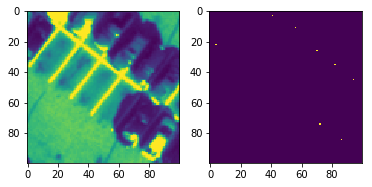

In [161]:
test_img = np.load("dataset/Columbus_CSUAV_AFRL/Columbus_82_147.npy")
test_img_a = np.load("dataset/Columbus_CSUAV_AFRL/Columbus_A_82_147.npy")

plt.subplot(121)
plt.imshow(test_img)
plt.subplot(122)
plt.imshow(test_img_a)

## Distribución de la data
Una vez se tiene la data lista para alimentar a la NN procederé a dividir esta en una porción de entrenamiento y otra para las pruebas. Primero es necesario cargar las matrices *.npy* que corresponden a las imágenes; posteriormente se dividirán las imágenes y las salidas ($[car, x, y]$) en dos grupos y se utilizará el conocido *sklearn.model_selection.train_test_split*. Debido a que **keras** necesita un formato específico de la data de entrenamiento se generaron las listas de ndarray's *X_train, X_test*, y los ndarray's *y_train, y_test*

In [1]:
from sklearn.model_selection import train_test_split

def load_train_test_split(data_frame, width, height, random_state=420):
    index = []
    for img_path in data_frame.img:
        img = np.load(img_path+'.npy')
        if img.shape[0] == height and img.shape[1] == width:
            index.append(True)
        else:
            index.append(False)

    clean_df = data_frame.loc[index,:]
    
    X = clean_df.img
    y = clean_df.loc[:, ['car', 'x', 'y']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    mat_list_1 = []
    for path in X_train:
        mat_list_1.append(np.load(path+'.npy'))
    X_train = np.dstack(mat_list_1).T
    
    mat_list_2 = []
    for path in X_test:
        mat_list_2.append(np.load(path+'.npy'))
    X_test = np.dstack(mat_list_2).T
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    
    return X_train, X_test, y_train, y_test

In [2]:
import pandas as pd
import numpy as np

df_Columbus = pd.read_csv("df_Columbus.csv")
X_train, X_test, y_train, y_test = load_train_test_split(df_Columbus, 100, 100)

In [3]:
print(X_train.shape)
print(X_test.shape)

(13203, 100, 100)
(4401, 100, 100)


In [23]:
print(len(y_train))
print(len(y_test))

13203
4401


Ahora bien, debido a la naturaleza de mi red neuronal debemos entrenarla a partir de una función de costo muy específica. De la teoría (que será profundizada en el informe final del trabajo) se consideran dos posibles salidas:
* $[1.0, x, y]$: De detectarse un automovil será necesario calcular la función de costo como la distancia euclideana conocida y bastamente utilizada en procesos de aprendizaje automático
* $[0.0, -1, -1]$: De no detectarse un automóvil solo se deberá considerar estrictamente las primeras componentes de este resultado y restarlas como una distancia unidimensional

Además, para realizar cálculos sobre la red neuronal no es recomendable usar los módulos conocidos como numpy o scipy. La documenatación recomienda usar los métodos implementados sobre keras en *tensorflow.keras.backend*. La función **custom_loss** implementada a continuación rescata todo esto:

In [24]:
import tensorflow.keras.backend as K
def custom_loss(y_true, y_pred):

    y_true_present = y_true[0:1,...]
    y_pred_present = y_pred[0:1,...]

    loss = K.sum(y_true_present*K.abs(y_pred[1:,...] - y_true[1:,...]),axis=-1)+ K.sum((1-y_true_present)*K.abs(y_true_present-y_pred_present),axis=-1)

    return loss

Si bien la data ya estaba lista para ser ingresada a la red, keras exige un redimensionamiento específico de mis matrices y listas, por lo que el siguiente bloque de código fue necesario.

In [ ]:
import tensorflow as tf
from tensorflow import keras

X_train_reshaped = X_train.reshape(np.concatenate((X_train.shape, 1), axis=None))
X_test_reshaped = X_test.reshape(np.concatenate((X_test.shape, 1), axis=None))

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

## Preparación de la CNN
Como se explicó en la propuesta de proyecto se empleará una red neuronal convolucional con una topolgía similar a la de AlexNet. Si bien esta estaba orientada a un output del orden de los miles de componentes, se modificaron ciertas capas para que se adecúe a la regresión que se necesita y para que los requerimientos computacionales no sean tan altos.
Para la implementación se utilizará **tensorflow** con **keras** de frontend. A lo largo de la estructura nos encontraremos con las siguientes capas:

* **Input:** Se esperará una matriz de 100x100
* **1era Convolución:** Se operará con 96 filtros usando un kernel de 11x11, iterando de 4 en 4 y usando la función de activación **rectified linear unit**
* **1er MaxPolling:** Se usará un max pooling para redimensionar las acracterísticas de la imágen
* **2da Convolución:** Se operará con 256 filtros usando un kernel de 5x5. Esta convolución será un **same convolution**
* **2do MaxPolling:** Idéntico al primero
* **3era Convolución:** Se operará con 384 filtros usando un kernel de 3x3. Esta convolución será un **same convolution**
* **4ta Convolución:** Idéntica a la tercera
* **3era Convolución:** Se operará con 256 filtros usando un kernel de 3x3. Esta convolución será un **same convolution**
* **3er MaxPolling:** Idéntico al primero
* **Flatten:** Se aplanará la matriz resultante para proceder a adjuntarla a la unidad *fully-connected*
* **1er Dense-Layer:** Ocupará 1024 neuronas usando relu como función de activación
* **Dropout:** Debido a problemas previos con el sobre-ajuste decidí añadir esta capa de dropout que desactiva ciertas neuronas para dotar de generalidad al modelo
* **2da Dense-Layer:** Idéntica a la primera
* **Output-Layer:** Capa de 3 neuronas con función de activación softmax para evaluar las 3 componentes de *y_predicted*

In [37]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(100,100,1)))
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4),activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5),padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(keras.layers.Dense(3, activation=tf.nn.softmax))

model.compile(loss=keras.metrics.msle, optimizer='adam',metrics=['accuracy'])

model.fit(X_train_reshaped, y_train, epochs=1)

Epoch 1/1
13203/13203 [==============================] - 304s 23ms/step - loss: 0.0824 - acc: 0.9971


In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 23, 23, 96)        11712     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 11, 11, 256)       614656    
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 5, 5, 256)         884992    
__________

## Pruebas
Luego de entrenar la red neuronal podemos alimentarla con elementos arbitrarios del set *X_test_reshaped* & *y_test*. Para esto buscamos una imágen cualquiera y la probamos con el método *model.predict()* que nos ofrece **keras.**

Y real: [0.36 0.48]
Prediccion: [0.31768903 0.36191523]
Error: [0.04231097 0.11808477]
Norma de error: 0.12543616223251317


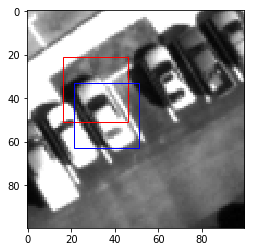

In [167]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Buscando imagen con algun auto presn
this = 0
for i in range(len(y_test)):
    if y_test[i][0] == 1.0: # Si se considera un auto
        this = i

y_real = y_test[this][1:]
y_real = np.array([y_real[1], y_real[0]])
print("Y real:",y_real)
prediccion = model.predict(np.array([X_test_reshaped[this]]))[0]
prediccion = np.array([prediccion[1], prediccion[0]])
print("Prediccion:",prediccion)
print("Error:", y_real-prediccion)
print("Norma de error:", np.linalg.norm(y_real-prediccion))

test_img = X_test_reshaped[this][:,:,0]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(test_img,cmap='gray')

segment_size = 30

bl_corner = (prediccion*100).astype(int)
bl_corner[0] -= segment_size//2
bl_corner[1] -= segment_size//2

rect = patches.Rectangle(bl_corner,segment_size,segment_size,linewidth=1,edgecolor='r',facecolor='none')

real_bl = (y_real*100).astype(int)
real_bl[0] -= segment_size//2
real_bl[1] -= segment_size//2

rect2 = patches.Rectangle(real_bl,segment_size,segment_size,linewidth=1,edgecolor='b',facecolor='none')
 

ax.add_patch(rect)
ax.add_patch(rect2)

plt.show()

## Alcance
Si bien modelos más complejos de reconocimiento y localización en imágenes entrenan una red neuronal no en un solo punto $x,y$, si no que consideran una caja de esqina $x, y$ y dimensiones $w, h$. Lamentablemente no se pudo replicar este modelo con resultados adecuados y se espera intentarlo para una siguiente entrega probando más imágenes a parte de la *Columbus*, la cual fue escogida por las limitaciones de poder computacional.
Además, es buen punto de partida el conseguido hasta este punto, pero solo para imágenes monocromáticas. Operar el modelo generado en una escala del triple de dimensiones presentaría problemas en la generación de las subimágenes, su normalización y la carga de las matrices; sin embargo, de superar estas dificultades el entrenamiento no se vería afectado en costo computacional gracias a las capas de convolución.